# Hand Gesture Recognition với Neural Network

Notebook này hướng dẫn xây dựng và training một neural network model để nhận dạng cử chỉ tay sử dụng hand landmarks từ MediaPipe.

## Mục tiêu:
- Load và khám phá dataset hand gesture 
- Tiền xử lý dữ liệu hand landmarks
- Xây dựng neural network architecture
- Training model với TensorFlow/Keras
- Đánh giá hiệu suất model
- Convert sang TensorFlow Lite để deploy
- Test inference với model đã train

## 1. Import Required Libraries

In [16]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("TensorFlow version:", tf.__version__)
print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)

TensorFlow version: 2.19.0
Pandas version: 2.3.1
NumPy version: 1.26.4


## 2. Load và Explore Dataset

In [19]:
# Đường dẫn đến dataset
dataset_path = 'dataset/hand_gestures_dataset.csv'

# Load dataset
print("Loading dataset...")
df = pd.read_csv(dataset_path)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {len(df.columns)}")
print("\nFirst few rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nGesture distribution:")
print(df['gesture_name'].value_counts())

print("\nHand type distribution:")
print(df['hand_0_type'].value_counts())

print("\nNumber of hands distribution:")
print(df['num_hands'].value_counts())

Loading dataset...
Dataset shape: (373, 90)
Columns: 90

First few rows:
                timestamp  class_id gesture_name  num_hands hand_0_type  \
0  20250807_161032_401448         2          two          1        Left   
1  20250807_161033_963409         2          two          1        Left   
2  20250807_161034_845662         2          two          2        Left   
3  20250807_161035_492472         2          two          1        Left   
4  20250807_161035_995513         2          two          1        Left   

   hand_0_landmark_0_x  hand_0_landmark_0_y  hand_0_landmark_1_x  \
0                  141                  418                  189   
1                  173                  455                  220   
2                  288                  417                  326   
3                  375                  464                  433   
4                  425                  456                  481   

   hand_0_landmark_1_y  hand_0_landmark_2_x  ...  hand_1_landmark_1

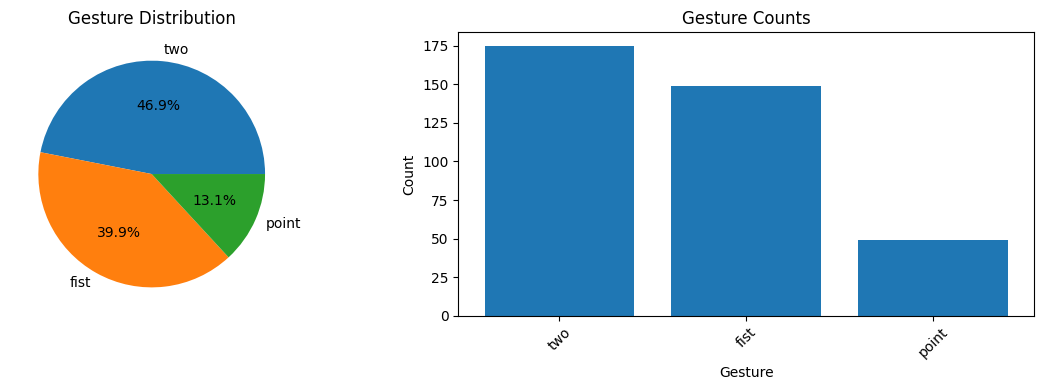


Dataset Summary:
Total samples: 373
Number of gestures: 3
Gesture classes: ['two', 'fist', 'point']
Missing values: 14921


In [20]:
# Visualize gesture distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
gesture_counts = df['gesture_name'].value_counts()
plt.pie(gesture_counts.values, labels=gesture_counts.index, autopct='%1.1f%%')
plt.title('Gesture Distribution')

plt.subplot(1, 2, 2)
plt.bar(gesture_counts.index, gesture_counts.values)
plt.title('Gesture Counts')
plt.xlabel('Gesture')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"\nDataset Summary:")
print(f"Total samples: {len(df)}")
print(f"Number of gestures: {df['gesture_name'].nunique()}")
print(f"Gesture classes: {list(df['gesture_name'].unique())}")
print(f"Missing values: {df.isnull().sum().sum()}")

## 3. Data Preprocessing

Xử lý dữ liệu để chuẩn bị cho việc training model. Chúng ta sẽ:
- Lọc ra chỉ các sample có 1 tay (đơn giản hóa)
- Extract tọa độ x,y của 21 landmarks
- Normalize dữ liệu
- Encode labels

In [21]:
# Filter data - chỉ lấy samples có 1 tay để đơn giản
df_filtered = df[df['num_hands'] == 1].copy()
print(f"Filtered dataset shape: {df_filtered.shape}")
print(f"Remaining gestures: {df_filtered['gesture_name'].value_counts()}")

# Tạo function để extract hand landmarks
def extract_hand_landmarks(row):
    """Extract x,y coordinates of 21 hand landmarks"""
    landmarks = []
    
    # Extract 21 landmarks (0-20) for hand_0
    for i in range(21):
        x_col = f'hand_0_landmark_{i}_x'
        y_col = f'hand_0_landmark_{i}_y'
        
        if x_col in row and y_col in row:
            landmarks.extend([row[x_col], row[y_col]])
        else:
            # Fill missing landmarks with 0
            landmarks.extend([0.0, 0.0])
    
    return np.array(landmarks)

# Extract features (42 features: 21 landmarks × 2 coordinates)
print("Extracting hand landmarks...")
X_data = []
y_data = []

for idx, row in df_filtered.iterrows():
    landmarks = extract_hand_landmarks(row)
    if len(landmarks) == 42:  # Ensure we have all 21 landmarks
        X_data.append(landmarks)
        y_data.append(row['gesture_name'])

X_data = np.array(X_data)
y_data = np.array(y_data)

print(f"Feature matrix shape: {X_data.shape}")
print(f"Labels shape: {y_data.shape}")
print(f"Feature range - min: {X_data.min():.2f}, max: {X_data.max():.2f}")

Filtered dataset shape: (347, 90)
Remaining gestures: gesture_name
two      157
fist     145
point     45
Name: count, dtype: int64
Extracting hand landmarks...
Feature matrix shape: (347, 42)
Labels shape: (347,)
Feature range - min: -13.00, max: 691.00


## 4. Feature Engineering và Normalization

Normalized feature range - min: 0.00, max: 1.00
Original labels: ['fist' 'point' 'two']
Encoded labels: [0 1 2]
Number of classes: 3
Scaler and label encoder saved!


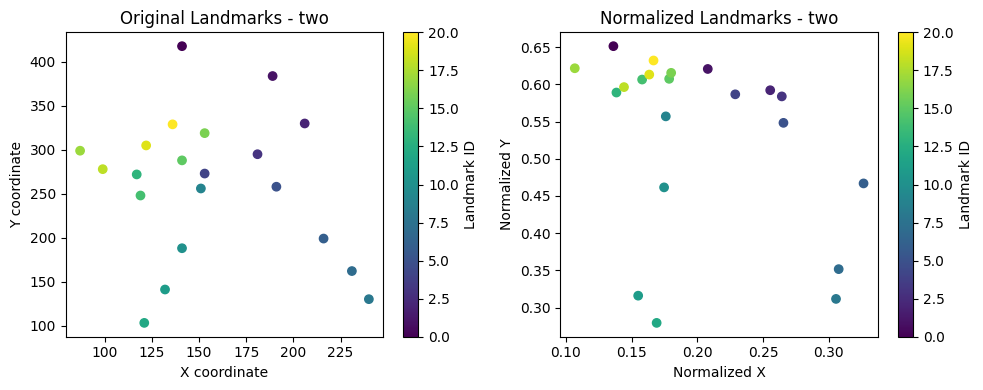

In [22]:
# Normalize features using MinMaxScaler
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_data)

print(f"Normalized feature range - min: {X_normalized.min():.2f}, max: {X_normalized.max():.2f}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_data)

print(f"Original labels: {label_encoder.classes_}")
print(f"Encoded labels: {np.unique(y_encoded)}")
print(f"Number of classes: {len(label_encoder.classes_)}")

# Save scaler and label encoder for later use
os.makedirs('model/neural_network', exist_ok=True)

with open('model/neural_network/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('model/neural_network/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print("Scaler and label encoder saved!")

# Visualize a sample of landmarks
plt.figure(figsize=(10, 4))

# Plot original vs normalized features for first sample
sample_idx = 0
original_landmarks = X_data[sample_idx].reshape(21, 2)
normalized_landmarks = X_normalized[sample_idx].reshape(21, 2)

plt.subplot(1, 2, 1)
plt.scatter(original_landmarks[:, 0], original_landmarks[:, 1], c=range(21), cmap='viridis')
plt.title(f'Original Landmarks - {y_data[sample_idx]}')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.colorbar(label='Landmark ID')

plt.subplot(1, 2, 2)
plt.scatter(normalized_landmarks[:, 0], normalized_landmarks[:, 1], c=range(21), cmap='viridis')
plt.title(f'Normalized Landmarks - {y_data[sample_idx]}')
plt.xlabel('Normalized X')
plt.ylabel('Normalized Y')
plt.colorbar(label='Landmark ID')

plt.tight_layout()
plt.show()

## 5. Train-Test Split

In [23]:
# Split data into train and test sets
try:
    # Try stratified split first
    X_train, X_test, y_train, y_test = train_test_split(
        X_normalized, y_encoded, 
        test_size=0.25, 
        random_state=RANDOM_SEED,
        stratify=y_encoded
    )
    print("Using stratified split")
except ValueError as e:
    print(f"Stratified split failed: {e}")
    print("Using simple random split")
    # Fallback to simple random split
    X_train, X_test, y_train, y_test = train_test_split(
        X_normalized, y_encoded, 
        test_size=0.25, 
        random_state=RANDOM_SEED
    )

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

# Check class distribution in train and test sets
print("\nClass distribution in training set:")
train_unique, train_counts = np.unique(y_train, return_counts=True)
for cls, count in zip(train_unique, train_counts):
    gesture_name = label_encoder.inverse_transform([cls])[0]
    print(f"  {gesture_name} (class {cls}): {count} samples")

print("\nClass distribution in test set:")
test_unique, test_counts = np.unique(y_test, return_counts=True)
for cls, count in zip(test_unique, test_counts):
    gesture_name = label_encoder.inverse_transform([cls])[0]
    print(f"  {gesture_name} (class {cls}): {count} samples")

Using stratified split
Training set shape: (260, 42)
Test set shape: (87, 42)
Training labels shape: (260,)
Test labels shape: (87,)

Class distribution in training set:
  fist (class 0): 109 samples
  point (class 1): 34 samples
  two (class 2): 117 samples

Class distribution in test set:
  fist (class 0): 36 samples
  point (class 1): 11 samples
  two (class 2): 40 samples


## 6. Model Architecture Setup

Tạo neural network architecture dựa trên project mẫu, được điều chỉnh cho dataset của chúng ta.

In [24]:
# Define model parameters
INPUT_SIZE = 42  # 21 landmarks × 2 coordinates
NUM_CLASSES = len(label_encoder.classes_)

print(f"Input size: {INPUT_SIZE}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Classes: {label_encoder.classes_}")

# Build neural network model (based on the sample project)
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((INPUT_SIZE,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Display model architecture
model.summary()

# Visualize model architecture
tf.keras.utils.plot_model(
    model, 
    to_file='model/neural_network/model_architecture.png',
    show_shapes=True, 
    show_layer_names=True,
    dpi=96
)

print("Model architecture saved as model_architecture.png")

Input size: 42
Number of classes: 3
Classes: ['fist' 'point' 'two']


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_2 (Dropout)             │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,103 (4.31 KB)

 Trainable params: 1,103 (4.31 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.
Model architecture saved as model_architecture.png
Model architecture saved as model_architecture.png


## 7. Model Training

In [25]:
# Define paths for saving model
model_save_path = 'model/neural_network/hand_gesture_model.h5'
checkpoint_path = 'model/neural_network/checkpoints/hand_gesture_model.h5'

# Create directories
os.makedirs('model/neural_network/checkpoints', exist_ok=True)

# Define callbacks
callbacks = [
    # Model checkpoint - save best model
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    # Early stopping - stop training if no improvement
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        verbose=1,
        restore_best_weights=True
    ),
    # Reduce learning rate on plateau
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        verbose=1,
        min_lr=1e-7
    )
]

# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")
print("Starting training...")

Model compiled successfully!
Starting training...


Epoch 1/1000
1/9 ━━━━━━━━━━━━━━━━━━━━ 4s 557ms/step - accuracy: 0.3125 - loss: 1.0664
Epoch 1: val_accuracy improved from None to 0.50575, saving model to model/neural_network/checkpoints/hand_gesture_model.h5

Epoch 1: val_accuracy improved from None to 0.50575, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3615 - loss: 1.0683 - val_accuracy: 0.5057 - val_loss: 1.0204 - learning_rate: 0.0010
Epoch 2/1000
Epoch 2/1000
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5000 - loss: 1.0120
Epoch 2: val_accuracy did not improve from 0.50575
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4654 - loss: 1.0299 - val_accuracy: 0.4828 - val_loss: 0.9982 - learning_rate: 0.0010
Epoch 3/1000

Epoch 2: val_accuracy did not improve from 0.50575
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4654 - loss: 1.0299 - val_accuracy: 0.4828 - val_loss: 0.9982 - learning_rate: 0.0010
Epoch 3/1000
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5625 - loss: 1.0038
Epoch 3: val_accuracy did not improve from 0.50575
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4885 - loss: 1.0388 - val_accuracy: 0.4828 - val_loss: 0.9871 - learning_rate: 0.0010
Epoch 4/1000

Epoch 3: val_accuracy did not improve from 0.50575
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5269 - loss: 0.9783 - val_accuracy: 0.5517 - val_loss: 0.9491 - learning_rate: 0.0010
Epoch 7/1000
Epoch 7/1000
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6250 - loss: 0.9357
Epoch 7: val_accuracy improved from 0.55172 to 0.58621, saving model to model/neural_network/checkpoints/hand_gesture_model.h5

Epoch 7: val_accuracy improved from 0.55172 to 0.58621, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5577 - loss: 0.9639 - val_accuracy: 0.5862 - val_loss: 0.9357 - learning_rate: 0.0010
Epoch 8/1000
Epoch 8/1000
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5312 - loss: 1.0051
Epoch 8: val_accuracy improved from 0.58621 to 0.66667, saving model to model/neural_network/checkpoints/hand_gesture_model.h5

Epoch 8: val_accuracy improved from 0.58621 to 0.66667, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5385 - loss: 0.9847 - val_accuracy: 0.6667 - val_loss: 0.9175 - learning_rate: 0.0010
Epoch 9/1000
Epoch 9/1000
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6562 - loss: 0.9170
Epoch 9: val_accuracy improved from 0.66667 to 0.75862, saving model to model/neural_network/checkpoints/hand_gesture_model.h5

Epoch 9: val_accuracy improved from 0.66667 to 0.75862, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5808 - loss: 0.9924 - val_accuracy: 0.7586 - val_loss: 0.9002 - learning_rate: 0.0010
Epoch 10/1000
Epoch 10/1000
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5938 - loss: 0.9955
Epoch 10: val_accuracy improved from 0.75862 to 0.77011, saving model to model/neural_network/checkpoints/hand_gesture_model.h5

Epoch 10: val_accuracy improved from 0.75862 to 0.77011, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6154 - loss: 0.9560 - val_accuracy: 0.7701 - val_loss: 0.8903 - learning_rate: 0.0010
Epoch 11/1000
Epoch 11/1000
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7188 - loss: 0.8609
Epoch 11: val_accuracy did not improve from 0.77011
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6154 - loss: 0.9380 - val_accuracy: 0.7471 - val_loss: 0.8794 - learning_rate: 0.0010
Epoch 12/1000

Epoch 11: val_accuracy did not improve from 0.77011
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6154 - loss: 0.9380 - val_accuracy: 0.7471 - val_loss: 0.8794 - learning_rate: 0.0010
Epoch 12/1000
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6875 - loss: 0.9128
Epoch 12: val_accuracy did not improve from 0.77011
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6115 - loss: 0.9296 - val_accuracy: 0.7471 - val_loss: 0.8701 - learning_rate: 0.0010
Epoch 13/1000

Epoch 12: val_accuracy did not improve from 0.77011
9/9 ━━━━━━━━━━━━━━━━━━━━ 

Model saved to model/neural_network/hand_gesture_model.h5



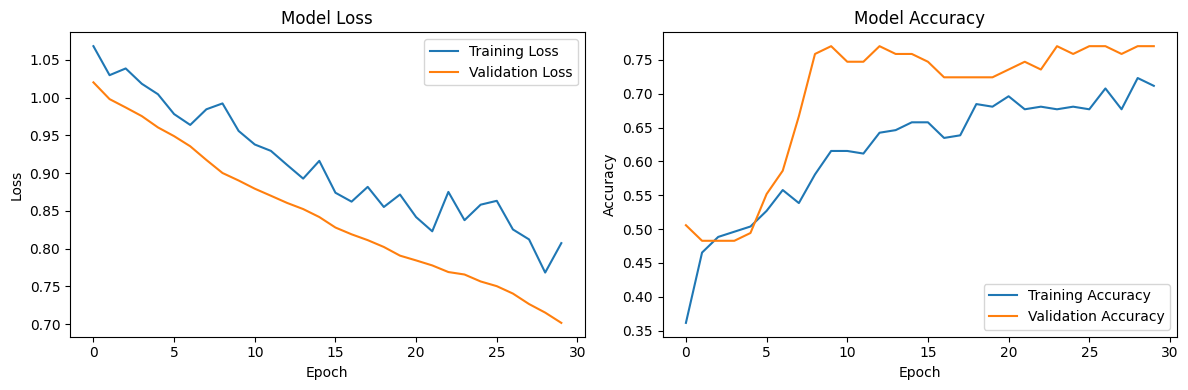


Final Training Results:
Training Loss: 0.8073
Training Accuracy: 0.7115
Validation Loss: 0.7016
Validation Accuracy: 0.7701


In [26]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=min(32, len(X_train)),  # Adjust batch size for small datasets
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

# Save final model
model.save(model_save_path, include_optimizer=False)
print(f"Model saved to {model_save_path}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('model/neural_network/training_history.png')
plt.show()

# Print final training results
final_train_loss = history.history['loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"\nFinal Training Results:")
print(f"Training Loss: {final_train_loss:.4f}")
print(f"Training Accuracy: {final_train_acc:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")
print(f"Validation Accuracy: {final_val_acc:.4f}")

## 8. Model Evaluation

Test Loss: 0.8903
Test Accuracy: 0.7701
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Detailed Test Results:
Accuracy: 0.7701

Detailed Test Results:
Accuracy: 0.7701


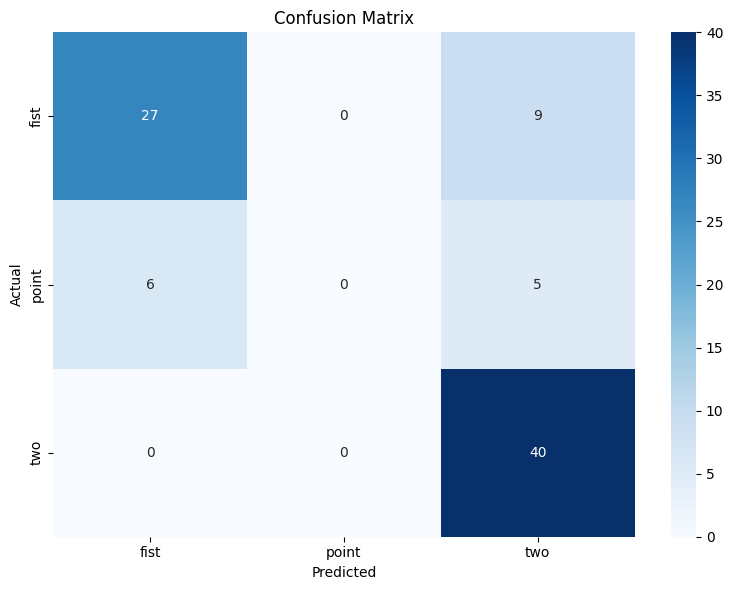


Classification Report:
              precision    recall  f1-score   support

        fist       0.82      0.75      0.78        36
       point       0.00      0.00      0.00        11
         two       0.74      1.00      0.85        40

    accuracy                           0.77        87
   macro avg       0.52      0.58      0.54        87
weighted avg       0.68      0.77      0.72        87


Per-class Results:
fist: Precision=0.818, Recall=0.750, F1=0.783, Support=36.0
point: Precision=0.000, Recall=0.000, F1=0.000, Support=11.0
two: Precision=0.741, Recall=1.000, F1=0.851, Support=40.0

Sample Predictions:
Sample 1: True=two, Predicted=two, Confidence=0.432
  Class probabilities:
    fist: 0.406
    point: 0.162
    two: 0.432

Sample 2: True=fist, Predicted=fist, Confidence=0.436
  Class probabilities:
    fist: 0.436
    point: 0.208
    two: 0.356

Sample 3: True=fist, Predicted=fist, Confidence=0.437
  Class probabilities:
    fist: 0.437
    point: 0.199
    two: 0.364

In [27]:
# Load best model for evaluation
best_model = tf.keras.models.load_model(checkpoint_path)

# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred_proba = best_model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"\nDetailed Test Results:")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig('model/neural_network/confusion_matrix.png')
    plt.show()
    
    return cm

# Plot confusion matrix
cm = plot_confusion_matrix(y_test, y_pred, label_encoder.classes_)

# Classification Report
print("\nClassification Report:")
report = classification_report(y_test, y_pred, 
                             target_names=label_encoder.classes_,
                             output_dict=True)
print(classification_report(y_test, y_pred, 
                          target_names=label_encoder.classes_))

# Per-class accuracy
print("\nPer-class Results:")
for i, class_name in enumerate(label_encoder.classes_):
    if class_name in report:
        precision = report[class_name]['precision']
        recall = report[class_name]['recall']
        f1 = report[class_name]['f1-score']
        support = report[class_name]['support']
        print(f"{class_name}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}, Support={support}")

# Sample predictions with confidence scores
print("\nSample Predictions:")
for i in range(min(5, len(X_test))):
    true_label = label_encoder.inverse_transform([y_test[i]])[0]
    pred_label = label_encoder.inverse_transform([y_pred[i]])[0]
    confidence = np.max(y_pred_proba[i])
    
    print(f"Sample {i+1}: True={true_label}, Predicted={pred_label}, Confidence={confidence:.3f}")
    
    # Show confidence for all classes
    print("  Class probabilities:")
    for j, class_name in enumerate(label_encoder.classes_):
        prob = y_pred_proba[i][j]
        print(f"    {class_name}: {prob:.3f}")
    print()

## 9. Model Optimization và TensorFlow Lite Conversion

Convert model sang TensorFlow Lite để deploy trên mobile hoặc embedded devices.

In [28]:
# Save model without optimizer for inference
inference_model_path = 'model/neural_network/hand_gesture_inference.h5'
best_model.save(inference_model_path, include_optimizer=False)

# Convert to TensorFlow Lite
tflite_model_path = 'model/neural_network/hand_gesture_model.tflite'

print("Converting model to TensorFlow Lite...")
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)

# Apply optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert model
tflite_model = converter.convert()

# Save TFLite model
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TensorFlow Lite model saved to {tflite_model_path}")

# Compare model sizes
import os

original_size = os.path.getsize(model_save_path)
tflite_size = os.path.getsize(tflite_model_path)

print(f"\nModel Size Comparison:")
print(f"Original Keras model: {original_size/1024:.2f} KB")
print(f"TensorFlow Lite model: {tflite_size/1024:.2f} KB")
print(f"Size reduction: {((original_size - tflite_size) / original_size) * 100:.1f}%")

# Create a representative dataset for quantization (optional)
def representative_dataset():
    for i in range(min(100, len(X_train))):
        yield [X_train[i:i+1].astype(np.float32)]

# Convert with quantization
print("\nConverting with quantization...")
converter_quantized = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter_quantized.optimizations = [tf.lite.Optimize.DEFAULT]
converter_quantized.representative_dataset = representative_dataset
converter_quantized.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_quantized.inference_input_type = tf.int8
converter_quantized.inference_output_type = tf.int8

tflite_quantized_model = converter_quantized.convert()

# Save quantized model
tflite_quantized_path = 'model/neural_network/hand_gesture_model_quantized.tflite'
with open(tflite_quantized_path, 'wb') as f:
    f.write(tflite_quantized_model)

quantized_size = os.path.getsize(tflite_quantized_path)
print(f"Quantized TensorFlow Lite model: {quantized_size/1024:.2f} KB")
print(f"Additional size reduction: {((tflite_size - quantized_size) / tflite_size) * 100:.1f}%")

Converting model to TensorFlow Lite...
INFO:tensorflow:Assets written to: C:\Users\Dell\AppData\Local\Temp\tmpt63hdm84\assets


INFO:tensorflow:Assets written to: C:\Users\Dell\AppData\Local\Temp\tmpt63hdm84\assets


Saved artifact at 'C:\Users\Dell\AppData\Local\Temp\tmpt63hdm84'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2439526180688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2439526183952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2439526174928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2439526182608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2439526184912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2439526180496: TensorSpec(shape=(), dtype=tf.resource, name=None)
TensorFlow Lite model saved to model/neural_network/hand_gesture_model.tflite

Model Size Comparison:
Original Keras model: 25.48 KB
TensorFlow Lite model: 6.36 KB
Size reduction: 75.0%

Converting with quantization...
TensorFlow Lite model saved to model/neural_network/hand_gesture_mode

INFO:tensorflow:Assets written to: C:\Users\Dell\AppData\Local\Temp\tmpbfwtfpvp\assets


Saved artifact at 'C:\Users\Dell\AppData\Local\Temp\tmpbfwtfpvp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2439526180688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2439526183952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2439526174928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2439526182608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2439526184912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2439526180496: TensorSpec(shape=(), dtype=tf.resource, name=None)
Quantized TensorFlow Lite model: 4.36 KB
Additional size reduction: 31.4%
Quantized TensorFlow Lite model: 4.36 KB
Additional size reduction: 31.4%


## 10. Inference Testing

Test các model đã convert với sample data để đảm bảo hoạt động chính xác.

In [29]:
# Test TensorFlow Lite model
def test_tflite_model(model_path, test_sample):
    """Test TensorFlow Lite model inference"""
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    
    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], test_sample)
    
    # Run inference
    interpreter.invoke()
    
    # Get output
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

# Test with first test sample
test_sample = X_test[0:1].astype(np.float32)

print("Testing inference on different model formats...")
print(f"Test sample shape: {test_sample.shape}")
print(f"True label: {label_encoder.inverse_transform([y_test[0]])[0]}")

# Original Keras model prediction
keras_pred = best_model.predict(test_sample, verbose=0)
keras_class = np.argmax(keras_pred)
keras_confidence = np.max(keras_pred)

print(f"\nKeras model:")
print(f"  Predicted class: {label_encoder.inverse_transform([keras_class])[0]}")
print(f"  Confidence: {keras_confidence:.4f}")
print(f"  Raw predictions: {keras_pred[0]}")

# TensorFlow Lite model prediction
tflite_pred = test_tflite_model(tflite_model_path, test_sample)
tflite_class = np.argmax(tflite_pred)
tflite_confidence = np.max(tflite_pred)

print(f"\nTensorFlow Lite model:")
print(f"  Predicted class: {label_encoder.inverse_transform([tflite_class])[0]}")
print(f"  Confidence: {tflite_confidence:.4f}")
print(f"  Raw predictions: {tflite_pred[0]}")

# Check if predictions match
predictions_match = np.allclose(keras_pred, tflite_pred, atol=1e-5)
print(f"\nPredictions match: {predictions_match}")
print(f"Max difference: {np.max(np.abs(keras_pred - tflite_pred)):.6f}")

# Benchmark inference speed
import time

def benchmark_model(model_func, test_data, num_runs=100):
    """Benchmark model inference speed"""
    times = []
    for _ in range(num_runs):
        start_time = time.time()
        _ = model_func(test_data)
        times.append(time.time() - start_time)
    
    return np.mean(times), np.std(times)

# Keras model benchmark
def keras_inference(data):
    return best_model.predict(data, verbose=0)

# TensorFlow Lite model benchmark
def tflite_inference(data):
    return test_tflite_model(tflite_model_path, data)

print("\nBenchmarking inference speed (100 runs):")

keras_time, keras_std = benchmark_model(keras_inference, test_sample)
print(f"Keras model: {keras_time*1000:.2f} ± {keras_std*1000:.2f} ms")

tflite_time, tflite_std = benchmark_model(tflite_inference, test_sample)
print(f"TensorFlow Lite: {tflite_time*1000:.2f} ± {tflite_std*1000:.2f} ms")

speedup = keras_time / tflite_time
print(f"Speedup: {speedup:.2f}x")

# Test all test samples
print("\nTesting all test samples...")
correct_keras = 0
correct_tflite = 0

for i in range(len(X_test)):
    sample = X_test[i:i+1].astype(np.float32)
    true_label = y_test[i]
    
    # Keras prediction
    keras_pred = best_model.predict(sample, verbose=0)
    keras_class = np.argmax(keras_pred)
    
    # TFLite prediction  
    tflite_pred = test_tflite_model(tflite_model_path, sample)
    tflite_class = np.argmax(tflite_pred)
    
    if keras_class == true_label:
        correct_keras += 1
    if tflite_class == true_label:
        correct_tflite += 1

keras_accuracy = correct_keras / len(X_test)
tflite_accuracy = correct_tflite / len(X_test)

print(f"Keras model accuracy: {keras_accuracy:.4f}")
print(f"TensorFlow Lite accuracy: {tflite_accuracy:.4f}")
print(f"Accuracy difference: {abs(keras_accuracy - tflite_accuracy):.6f}")

Testing inference on different model formats...
Test sample shape: (1, 42)
True label: two

Keras model:
  Predicted class: two
  Confidence: 0.4324
  Raw predictions: [0.40556955 0.16202833 0.4324021 ]

TensorFlow Lite model:
  Predicted class: two
  Confidence: 0.4324
  Raw predictions: [0.40556955 0.16202831 0.4324021 ]

Predictions match: True
Max difference: 0.000000

Benchmarking inference speed (100 runs):
Keras model: 51.42 ± 2.39 ms
TensorFlow Lite: 0.17 ± 0.37 ms
Speedup: 311.04x

Testing all test samples...
Keras model: 51.42 ± 2.39 ms
TensorFlow Lite: 0.17 ± 0.37 ms
Speedup: 311.04x

Testing all test samples...
Keras model accuracy: 0.7701
TensorFlow Lite accuracy: 0.7701
Accuracy difference: 0.000000
Keras model accuracy: 0.7701
TensorFlow Lite accuracy: 0.7701
Accuracy difference: 0.000000
